# Package & environment setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.17.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available? True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/nba_shot_prediction')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame()
for file in os.listdir(("data")):
    temp = pd.read_csv(f"data/{file}")
    df = pd.concat([df, temp])

In [ ]:
df.columns

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')

# Feature processing

### Problem of 'Player name' feature
* Who is the player that made a shot, is very important feature.
* However, it is very difficult to put it as categorical values.

Now, let's think about, 'why' is the player name important.
When we see James Harden shoots 3 pointer, know that 'historically', since he made many 3 pointer shots, he is the one wh's good at shot. So, it's all about historical data of each player's shoot success.

So, I would like to

1. Make ave_soot_stat dictionary for all players.
2. Replace player's name with their ave shoot success rate.
3. When predicting, we can refer to the dictionary, to use that player's avg_shoot_stat.

In [ ]:
players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

In [ ]:
df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])

In [ ]:
df[["TEAM_ID", "TEAM_NAME", "PLAYER_ID", "PLAYER_NAME", "PLAYER_AVG_SHOT_RATE"]].head(
    10
)

,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,PLAYER_AVG_SHOT_RATE
0,1610612764,Washington Wizards,203078,Bradley Beal,0.47
1,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
2,1610612764,Washington Wizards,1628420,Monte Morris,0.48
3,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
4,1610612764,Washington Wizards,1630166,Deni Avdija,0.46
5,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
6,1610612764,Washington Wizards,1628420,Monte Morris,0.48
7,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45
8,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45
9,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45


# Preprocessing features

Now, we should preprocess the features. Howeverm we will make some assumptions.

First, I will only predict shot success probability based on the conditions related to the games, and individual capability of the players.
Which means, I will not use 'TEAM' information. There are two reasons.

First, shot success rate prediction should be more focused on 'the moment'. For instance, GSW could have high 3 pt success rate because of Stephen Curry. This does not mean that any other players in GSW should have advantage when computing probability of shot success.

If we are using regression based model (e.g. Logistic regression), meaningful feaeture should add information helpful for prediction of the target. Here, we are asumming that knowing which team is the player in does not help predict his shot success rate.

Second, like player name encoding teams into categorical data will increase number of features to large extent, increasing complexity of the model.

In [ ]:
df.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,PLAYER_AVG_SHOT_RATE
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,10-19-2022,22200004,...,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20,0.47
1,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,24+ ft.,-0.4,31.45,26,1,10,52,0.46
2,2023,2022-23,1610612764,Washington Wizards,1628420,Monte Morris,G,PG,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-1.3,5.25,1,1,10,39,0.48
3,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-0.1,7.25,2,1,10,31,0.46
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5,0.46


For HOME / AWAY, rather if the player was at home / away could be meaningful. Therefore, I will process the data to get 'if_player_home'


In [ ]:
df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

In [ ]:
nba_team_abbreviations = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BKN",
    "Charlotte Hornets": "CHA",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}

df["IS_PLAYER_HOME"] = df["TEAM_NAME"] == df["HOME_TEAM"]

In [ ]:
players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])

df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

player_2pt_stat = {}
for p in players:
    temp = df.loc[(df["PLAYER_ID"] == p) & (df["SHOT_TYPE"] == "2PT Field Goal")][
        "SHOT_MADE"
    ]
    if temp.shape[0] == 0:
        avg = 0
    else:
        avg = round(sum(temp.values) / temp.shape[0], 2)
    player_2pt_stat[p] = avg

player_3pt_stat = {}
for p in players:
    temp = df.loc[(df["PLAYER_ID"] == p) & (df["SHOT_TYPE"] == "3PT Field Goal")][
        "SHOT_MADE"
    ]

    if temp.shape[0] == 0:
        avg = 0
    else:
        avg = round(sum(temp.values) / temp.shape[0], 2)
    player_3pt_stat[p] = avg

In [ ]:
df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])
df["PLAYER_AVG_2PT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_2pt_stat[x])
df["PLAYER_AVG_3PT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_3pt_stat[x])
df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

In [ ]:
df.to_csv("processed_data.csv", index=False)

In [4]:
df = pd.read_csv("processed_data.csv")

In [29]:
grouped_df1 = df.groupby("PLAYER_ID").agg({
    "PLAYER_NAME": "first",  # Take the first name in each group
    "PLAYER_AVG_3PT_RATE": "mean",  # Calculate the mean of 3PT rate
})

In [36]:
np.mean(grouped_df["3PT_SHOTS_PER_GAME"])

5.992397682615872

In [37]:
np.std(grouped_df["3PT_SHOTS_PER_GAME"])

3.5754498682249647

In [39]:
np.mean(grouped_df["TOTAL_3PT_ATTEMPTS"])

1475.444837340877

In [38]:
np.std(grouped_df["TOTAL_3PT_ATTEMPTS"])

2214.931973820959

# Processing Positions

In [ ]:
df['POSITION']

,POSITION
0,SG
1,C
2,PG
3,C
4,SF
...,...
218696,SG
218697,C
218698,C
218699,SG


In [ ]:
positions = ['C', 'PF', 'SF', 'SG', 'PG']
df['POSITION'] = df['POSITION'].fillna('').astype(str)
# Create columns for each position
for pos in positions:
    df['POSITION_' + pos] = df['POSITION'].apply(lambda x: 1 if pos in x else 0)

# Interaction terms

In [ ]:

df["interaction_term_distance_3ptrate"] = (
    df["SHOT_DISTANCE"] * df["PLAYER_AVG_3PT_RATE"]
)

df["interaction_term_distance_2ptrate"] = (
    df["SHOT_DISTANCE"] * df["PLAYER_AVG_2PT_RATE"]
)


df["interaction_term_distance_playerrate"] = (
    df["SHOT_DISTANCE"] * df["PLAYER_AVG_SHOT_RATE"]
)

df["distance_sqiared"] = df["SHOT_DISTANCE"] ** 2


df["interaction_term_2pt_3pt"] = (
    df["PLAYER_AVG_3PT_RATE"] * df["PLAYER_AVG_2PT_RATE"]
)

In [ ]:
numerical = [
    "PLAYER_AVG_SHOT_RATE",
    "PLAYER_AVG_3PT_RATE",
    "PLAYER_AVG_2PT_RATE",
    "LOC_X",
    "LOC_Y",
    "SHOT_DISTANCE",
    "QUARTER",
    "SECS_LEFT",
    "interaction_term_distance_3ptrate",
    "interaction_term_distance_2ptrate",
    "interaction_term_distance_playerrate",
    "distance_sqiared",
    "interaction_term_2pt_3pt",
    #"MINS_LEFT", Redundant

]

categorical = [
    #"ZONE_NAME",
    "ACTION_TYPE",
    "SHOT_TYPE",
    #"SEASON_2",
    "ZONE_ABB",
    "ZONE_RANGE",
    "BASIC_ZONE",
    "IS_PLAYER_HOME"
    #"POSITION",
    #"POSITION_GROUP",
]

position_labels  = ['POSITION_C',
    'POSITION_PF',
    'POSITION_SF',
    'POSITION_SG',
    'POSITION_PG']

In [ ]:
df[numerical].head()

,PLAYER_AVG_SHOT_RATE,PLAYER_AVG_3PT_RATE,PLAYER_AVG_2PT_RATE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,SECS_LEFT,interaction_term_distance_3ptrate,interaction_term_distance_2ptrate,interaction_term_distance_playerrate,distance_sqiared,interaction_term_2pt_3pt
0,0.47,0.37,0.52,23.4,12.95,24,1,20,8.88,12.48,11.28,576,0.1924
1,0.46,0.36,0.51,-0.4,31.45,26,1,52,9.36,13.26,11.96,676,0.1836
2,0.48,0.39,0.53,-1.3,5.25,1,1,39,0.39,0.53,0.48,1,0.2067
3,0.46,0.36,0.51,-0.1,7.25,2,1,31,0.72,1.02,0.92,4,0.1836
4,0.46,0.33,0.54,1.8,7.15,2,1,5,0.66,1.08,0.92,4,0.1782


In [ ]:
df[categorical].head()

,ACTION_TYPE,SHOT_TYPE,ZONE_ABB,ZONE_RANGE,BASIC_ZONE,IS_PLAYER_HOME
0,Jump Shot,3PT Field Goal,L,24+ ft.,Left Corner 3,False
1,Step Back Jump shot,3PT Field Goal,C,24+ ft.,Above the Break 3,False
2,Running Finger Roll Layup Shot,2PT Field Goal,C,Less Than 8 ft.,Restricted Area,False
3,Cutting Dunk Shot,2PT Field Goal,C,Less Than 8 ft.,Restricted Area,False
4,Cutting Dunk Shot,2PT Field Goal,C,Less Than 8 ft.,Restricted Area,False


In [ ]:
df[position_labels].head()

,POSITION_C,POSITION_PF,POSITION_SF,POSITION_SG,POSITION_PG
0,0,0,0,1,0
1,1,0,0,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,1,0,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

# Scaling
numerical_scaled = scaler.fit_transform(df[numerical])
numerical_scaled = pd.DataFrame(numerical_scaled, columns=df[numerical].columns)


# ONE-HOT Encoding
categorical_encoded = encoder.fit_transform(df[categorical])
categorical_encoded = pd.DataFrame(
    categorical_encoded, columns=encoder.get_feature_names_out()
)

In [ ]:
X_transformed = pd.concat([numerical_scaled, categorical_encoded, df[position_labels].reset_index(drop=True)], axis=1)
y = df["TARGET"]

In [ ]:
X_transformed.head()

,PLAYER_AVG_SHOT_RATE,PLAYER_AVG_3PT_RATE,PLAYER_AVG_2PT_RATE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,SECS_LEFT,interaction_term_distance_3ptrate,interaction_term_distance_2ptrate,...,BASIC_ZONE_Left Corner 3,BASIC_ZONE_Mid-Range,BASIC_ZONE_Restricted Area,BASIC_ZONE_Right Corner 3,IS_PLAYER_HOME_False,POSITION_C,POSITION_PF,POSITION_SF,POSITION_SG,POSITION_PG
0,0.152199,0.460891,0.150606,2.494160,0.100408,1.039776,-1.305991,-0.506519,1.113668,1.110580,...,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0
1,-0.030534,0.327509,-0.043431,-0.051184,2.263420,1.231829,-1.305991,1.329183,1.239315,1.258742,...,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0
2,0.334933,0.727656,0.344644,-0.147437,-0.799872,-1.168833,-1.305991,0.583429,-1.108710,-1.159341,...,0.0,0.0,1.0,0.0,1.0,0,0,0,0,1
3,-0.030534,0.327509,-0.043431,-0.019100,-0.566033,-1.072807,-1.305991,0.124503,-1.022328,-1.066265,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,0
4,-0.030534,-0.072638,0.538681,0.184099,-0.577725,-1.072807,-1.305991,-1.367004,-1.038034,-1.054868,...,0.0,0.0,1.0,0.0,1.0,0,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_val, y_val):
    y_pred_prob = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)  # Diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Models

## LR

Accuracy: 0.6273686497817487
Precision: 0.6531374988146174
Recall: 0.40636659274144565
F1-Score: 0.5010141293464214
Logistic Regression:


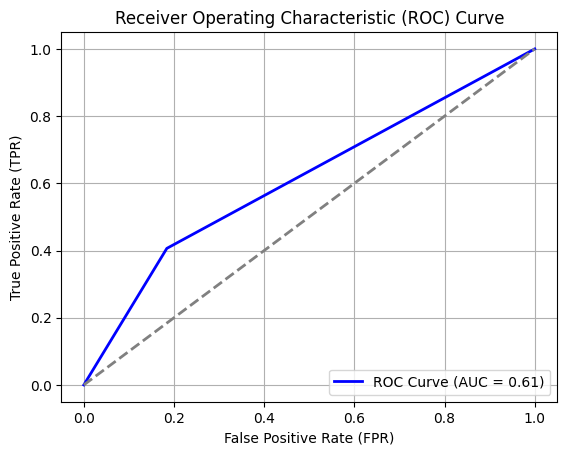

<ipython-input-41-3433f18619fb>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


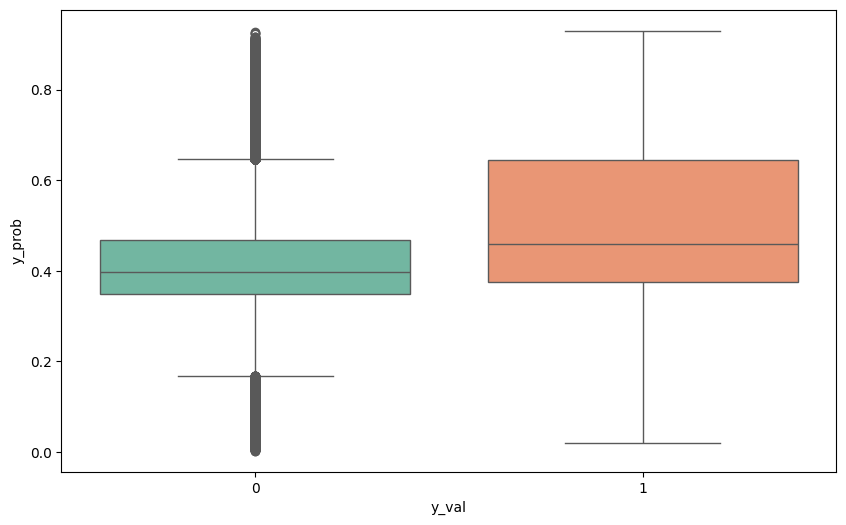

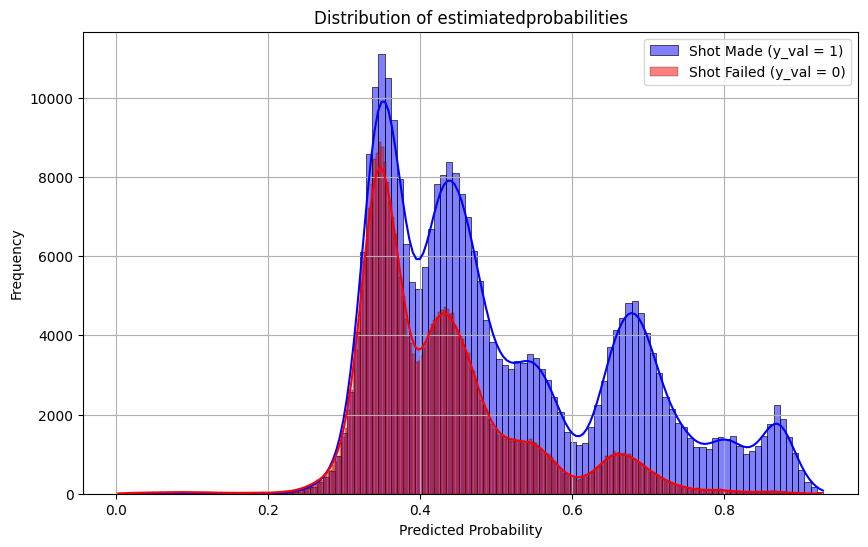

In [ ]:
logistic_regression = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters


X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_val)
y_prob = logistic_regression.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

print("Logistic Regression:")
plot_roc_curve(logistic_regression, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## XGBoost

Accuracy: 0.6401937100165526
Precision: 0.6829716465471123
Recall: 0.40763685710220077
F1-Score: 0.5105487708133649


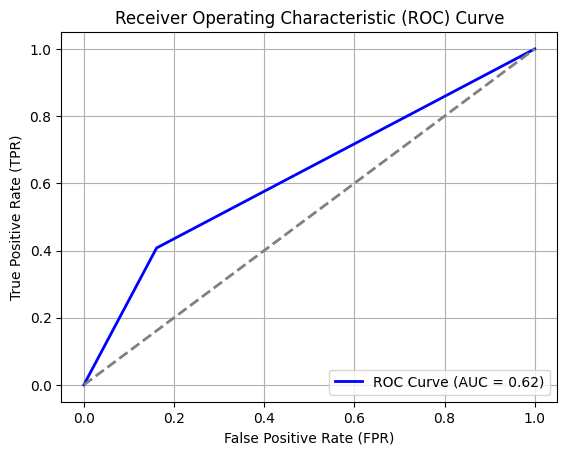

<ipython-input-42-62917a3819ff>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


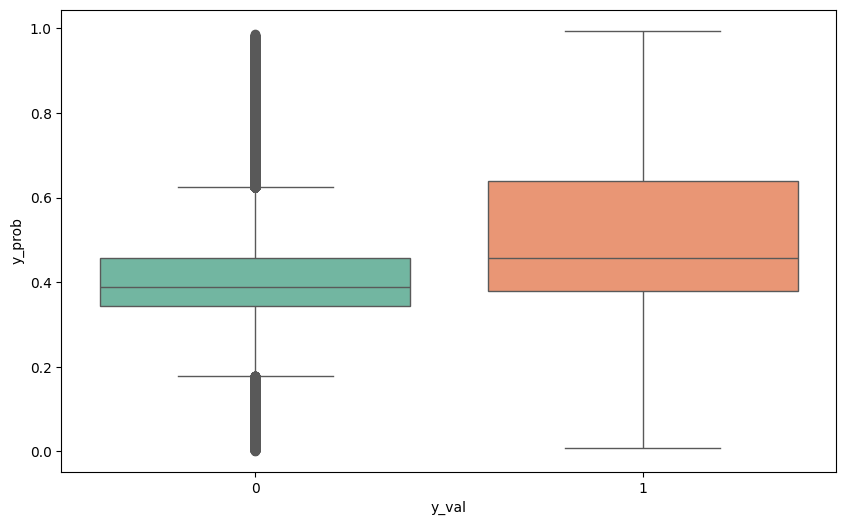

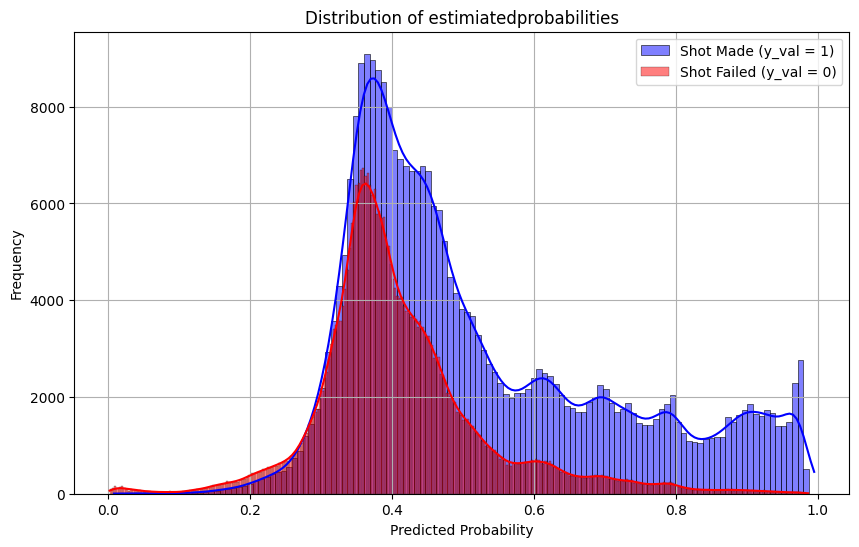

In [ ]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_val)
y_prob = XGB.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Feature importance

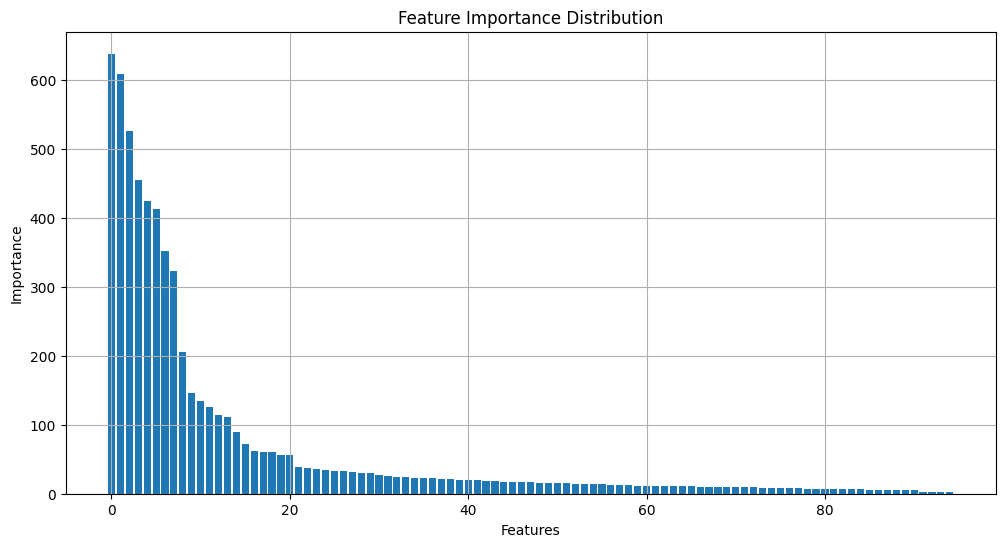

In [ ]:
# Retrieve feature importance
importance = XGB.get_booster().get_score(importance_type='gain')

# Convert to a sorted list of features
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [fet for fet, _ in sorted_importance]
score = [scor for _, scor in sorted_importance]
importance_df = pd.DataFrame({"Feature" : features[1:], "Importance" : score[1:]})

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_df)), importance_df["Importance"])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Distribution")
plt.grid(True)
plt.show()

In [ ]:
sorted_importance

[('SHOT_DISTANCE', 1376.1505126953125),
 ('ACTION_TYPE_Layup Shot', 637.9370727539062),
 ('ACTION_TYPE_Tip Layup Shot', 608.80810546875),
 ('ACTION_TYPE_Driving Layup Shot', 526.316650390625),
 ('ACTION_TYPE_Cutting Dunk Shot', 454.4661560058594),
 ('ACTION_TYPE_Running Dunk Shot', 424.78021240234375),
 ('ACTION_TYPE_Jump Shot', 412.66925048828125),
 ('ACTION_TYPE_Dunk Shot', 351.41644287109375),
 ('ACTION_TYPE_Alley Oop Dunk Shot', 322.41845703125),
 ('ACTION_TYPE_Driving Dunk Shot', 205.3152618408203),
 ('ACTION_TYPE_Cutting Layup Shot', 145.9002685546875),
 ('ACTION_TYPE_Tip Shot', 133.93728637695312),
 ('ACTION_TYPE_Cutting Finger Roll Layup Shot', 125.99629211425781),
 ('ACTION_TYPE_Running Finger Roll Layup Shot', 114.67867279052734),
 ('ACTION_TYPE_Putback Dunk Shot', 110.86448669433594),
 ('ACTION_TYPE_Running Alley Oop Dunk Shot', 89.17518615722656),
 ('ACTION_TYPE_Driving Finger Roll Layup Shot', 72.29660034179688),
 ('ACTION_TYPE_Driving Floating Bank Jump Shot', 62.61275100

In [ ]:
thred = 10

feature_importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
selected_features = feature_importance_df[feature_importance_df["Importance"]>thred]

# Re-trying XGB with selected feature

In [ ]:
X_transformed_new = X_transformed[selected_features.Feature.values]

## XGB

Accuracy: 0.6393580919147958
Precision: 0.6836455445894172
Recall: 0.4031631664983393
F1-Score: 0.5072110661374621


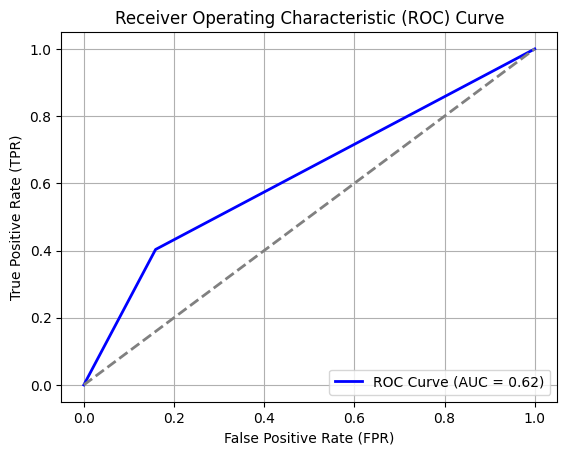

<ipython-input-51-53709d2b740e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


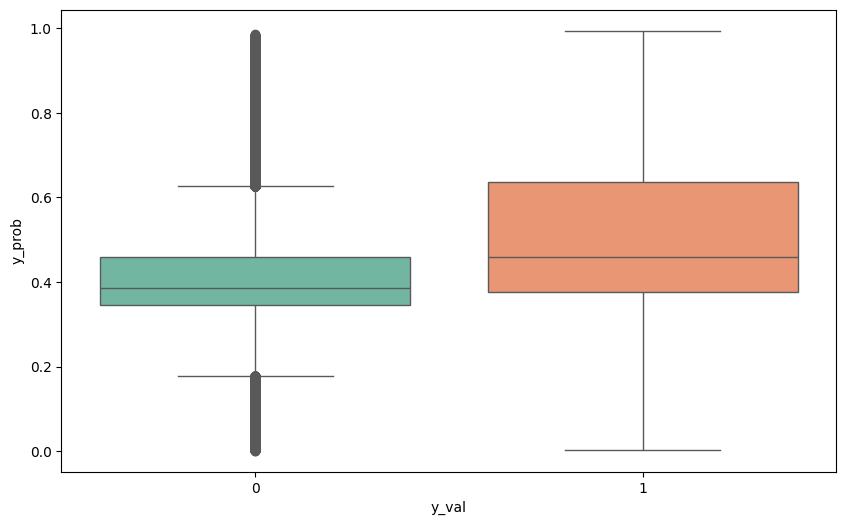

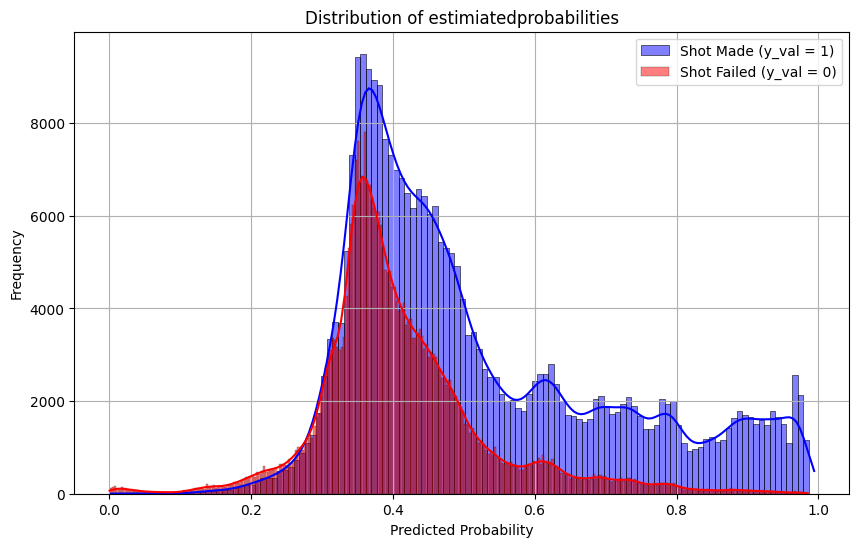

In [ ]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    X_transformed_new, y, test_size=0.3, random_state=20
)

XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_val)
y_prob = XGB.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

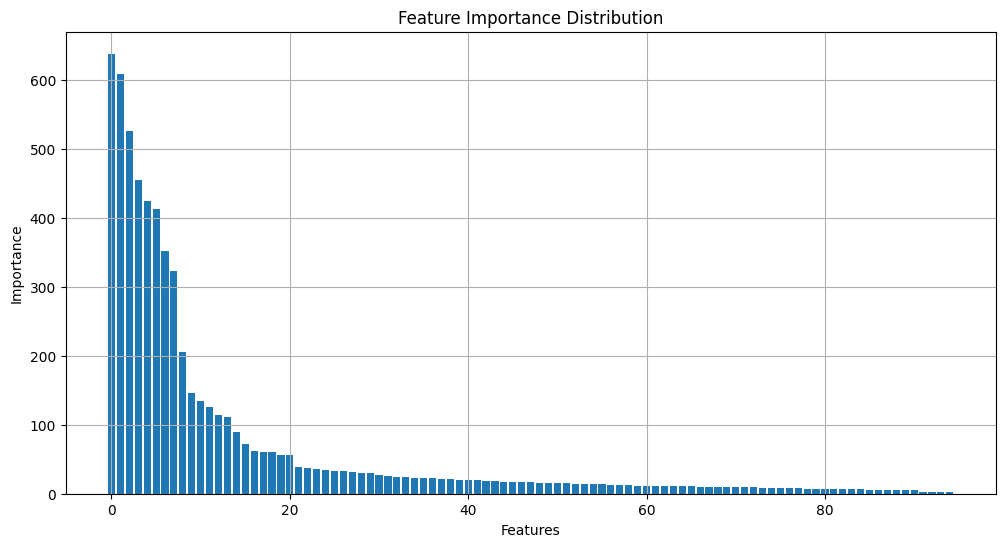

In [ ]:
# Retrieve feature importance
importance = XGB.get_booster().get_score(importance_type='gain')

# Convert to a sorted list of features
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

importance_df = pd.DataFrame({"Feature" : features[1:], "Importance" : score[1:]})

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_df)), importance_df["Importance"])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Distribution")
plt.grid(True)
plt.show()

In [ ]:
sorted_importance

[('SHOT_DISTANCE', 755.5145263671875),
 ('ACTION_TYPE_Tip Layup Shot', 668.5679321289062),
 ('ACTION_TYPE_Layup Shot', 579.263427734375),
 ('ACTION_TYPE_Running Dunk Shot', 421.6036071777344),
 ('ACTION_TYPE_Cutting Dunk Shot', 414.2796936035156),
 ('ACTION_TYPE_Jump Shot', 392.033203125),
 ('ACTION_TYPE_Driving Layup Shot', 297.1868591308594),
 ('ACTION_TYPE_Dunk Shot', 292.3132629394531),
 ('ACTION_TYPE_Alley Oop Dunk Shot', 256.6943664550781),
 ('ACTION_TYPE_Driving Dunk Shot', 165.5672149658203),
 ('ACTION_TYPE_Tip Shot', 136.53550720214844),
 ('ACTION_TYPE_Cutting Layup Shot', 111.692138671875),
 ('ACTION_TYPE_Cutting Finger Roll Layup Shot', 100.7684326171875),
 ('ACTION_TYPE_Running Finger Roll Layup Shot', 98.44975280761719),
 ('ACTION_TYPE_Putback Dunk Shot', 89.73725891113281),
 ('ACTION_TYPE_Running Alley Oop Dunk Shot', 78.72267150878906),
 ('ACTION_TYPE_Driving Bank shot', 59.99473190307617),
 ('BASIC_ZONE_Backcourt', 58.15749740600586),
 ('ACTION_TYPE_Slam Dunk Shot', 51.

# Neural Net

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

# Early stopping based on AUC (if you're tracking probabilistic performance)
early_stopping = EarlyStopping(
    monitor="val_auc",
    patience=10,
    mode="max",  # Higher AUC is better
    restore_best_weights=True
)

# Define the hyperparameters
parameters = {
    "layers": [
        [64, 32, 16],
        #[32, 16],
    ],
    "dropout_rates": [
        #0.1,
        0.2,
        #0.3
                      ],
    "learning_rate": [
        0.001,
        #0.0005
                      ],
    "batch_size": [
        32,
        #64
        ],
}
epochs = 50

# Function to build and optimize the model
def build_final_model(parameters, X_train, X_val, y_train, y_val):
    best_model = None
    best_val_auc = float('-inf')  # Track the best AUC (higher is better)
    best_history = None
    best_params = None

    # Grid search over parameters
    for layers in parameters["layers"]:
        for dropout_rate in parameters["dropout_rates"]:
            for learning_rate in parameters["learning_rate"]:
                for batch_size in parameters["batch_size"]:
                    # Build the model
                    model = Sequential()
                    model.add(
                        Dense(units=layers[0], input_dim=X_train.shape[1], activation="relu", kernel_regularizer=l2(0.01))
                    )
                    for hidden in layers[1:]:
                        model.add(Dense(units=hidden, activation="relu", kernel_regularizer=l2(0.01)))
                        model.add(Dropout(dropout_rate))

                    model.add(Dense(units=1, activation="sigmoid"))  # Sigmoid for probability output

                    # Compile the model with binary cross-entropy
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(
                        optimizer=optimizer,
                        loss="binary_crossentropy",  # Log loss for probabilistic binary classification
                        metrics=["accuracy", AUC(name='auc')]  # Include AUC for probabilistic evaluation
                    )

                    # Train the model
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[early_stopping]
                    )

                    # Evaluate the model
                    eval_metrics = model.evaluate(X_val, y_val, verbose=0)
                    val_auc = eval_metrics[2]  # AUC is the third metric in the list

                    print(f"Validation AUC: {val_auc}")

                    # Track the best model based on AUC
                    if val_auc > best_val_auc:
                        best_val_auc = val_auc
                        best_model = model
                        best_history = history
                        best_params = {"layers": layers, "dropout_rate": dropout_rate, "learning_rate": learning_rate, "batch_size": batch_size}

    print(f"Best Validation AUC: {best_val_auc}")
    print(f"Best Parameters: {best_params}")
    return best_model, best_history, best_params


In [ ]:
best_model_output = build_final_model(parameters, X_train, X_val, y_train, y_val)


best_model = best_model_output[0]
best_params = best_model_output[-1]

!mkdir -p saved_model
tf.saved_model.save(best_model, 'saved_model/my_model_V5_feature_eng')
saved_model = tf.saved_model.load('saved_model/my_model_V5_feature_eng')

print(best_params)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation AUC: 0.6604586243629456
Best Validation AUC: 0.6604586243629456
Best Parameters: {'layers': [32, 16], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
{'layers': [32, 16], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
Accuracy: 0.6345504917844201
Precision: 0.7052352258278511
Recall: 0.35420245792683136
F1-Score: 0.47156346094755347
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


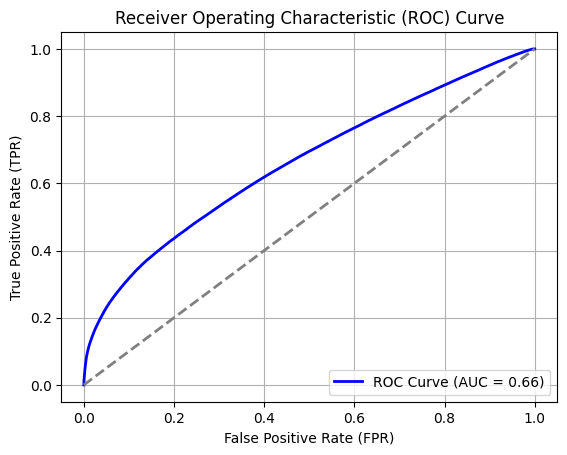

<ipython-input-61-12ea622b3651>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


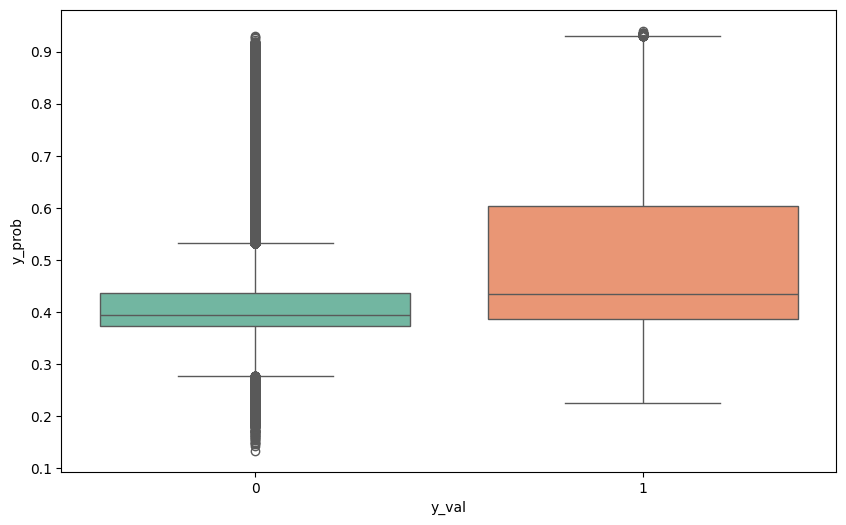

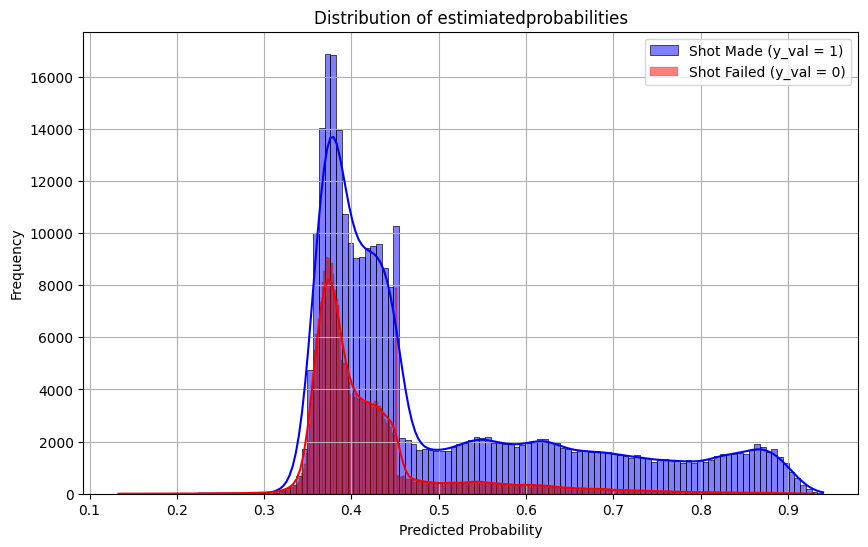

In [ ]:
def get_prediction_classes(neural_net, threshold, X):

    y_prob = neural_net.predict(X)
    threshold = threshold
    y_pred = (y_prob > threshold).astype(
        "int32"
    )  # Convert probabilities to class labels
    return (y_prob, y_pred)


y_pred = get_prediction_classes(best_model, 0.5, X_val)[1]
y_prob = get_prediction_classes(best_model, 0.5, X_val)[0]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(best_model, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob[:, 0]})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Building dedicated model for 3-point shots

In [ ]:
X_transformed["label"] = y.values

In [ ]:
three_pt_X_transfromed = X_transformed[X_transformed["SHOT_TYPE_3PT Field Goal"]==1]
two_pt_X_transfromed = X_transformed[X_transformed["SHOT_TYPE_2PT Field Goal"]==1]

In [ ]:
y_three_pt = three_pt_X_transfromed["label"]
y_two_pt = two_pt_X_transfromed["label"]

three_pt_X_transfromed = three_pt_X_transfromed.drop(columns=["label"])
two_pt_X_transfromed = two_pt_X_transfromed.drop(columns=["label"])

Accuracy: 0.6368517102764556
Precision: 0.6853314344899016
Recall: 0.5539267214931578
F1-Score: 0.6126623299760369


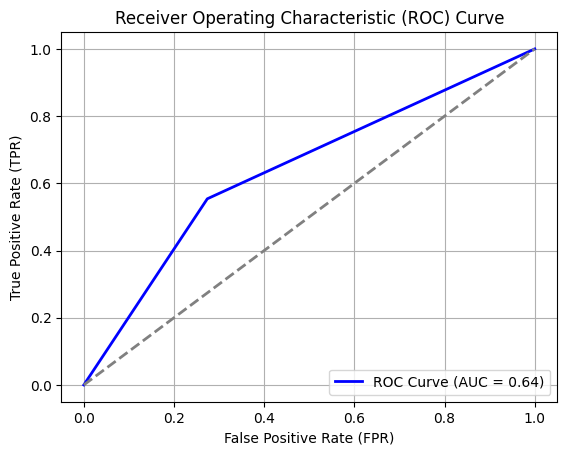

<ipython-input-81-9e16f9754aae>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


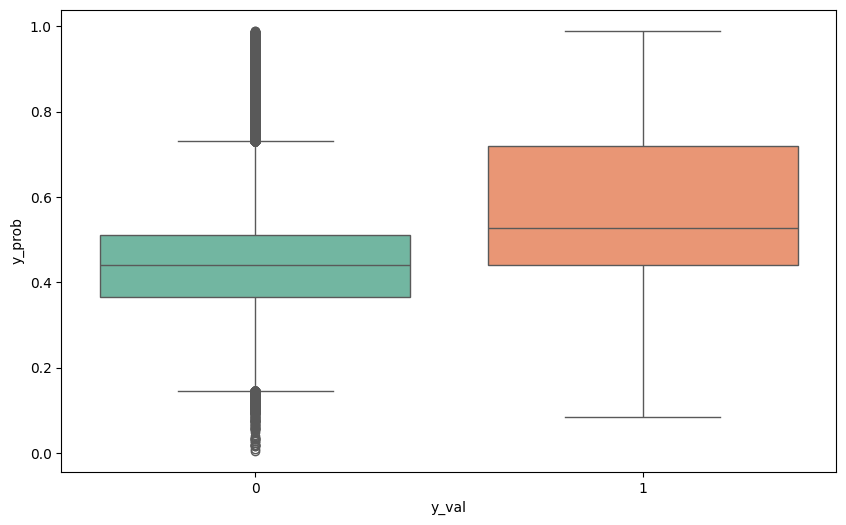

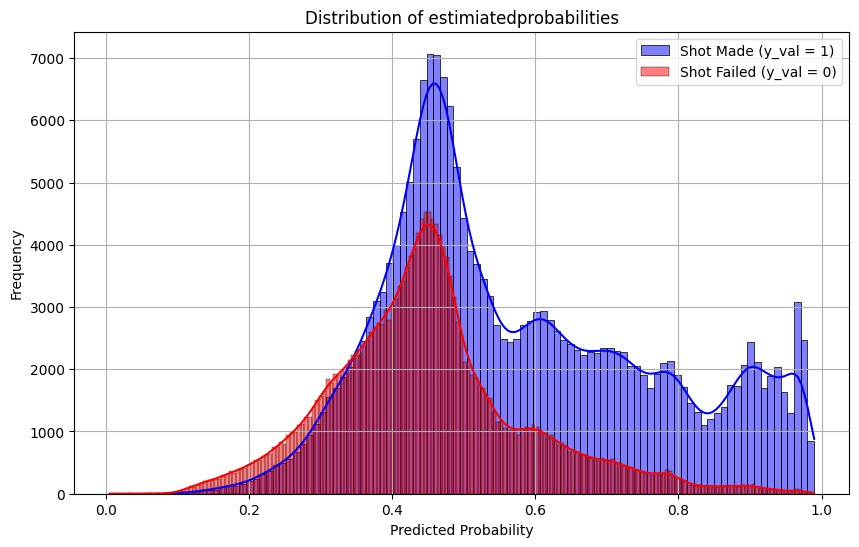

In [ ]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    two_pt_X_transfromed, y_two_pt, test_size=0.3, random_state=20
)

XGB_2pt = XGBClassifier(objective="binary:logistic")
XGB_2pt.fit(X_train, y_train)

y_pred = XGB_2pt.predict(X_val)
y_prob = XGB_2pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB_2pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.639120669706663
Precision: 0.4591243703990701
Recall: 0.014938543964702174
F1-Score: 0.028935609112885504


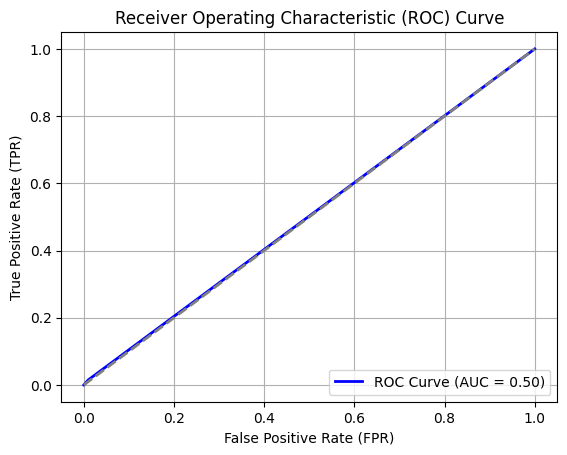

<ipython-input-82-d2c701aebc18>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


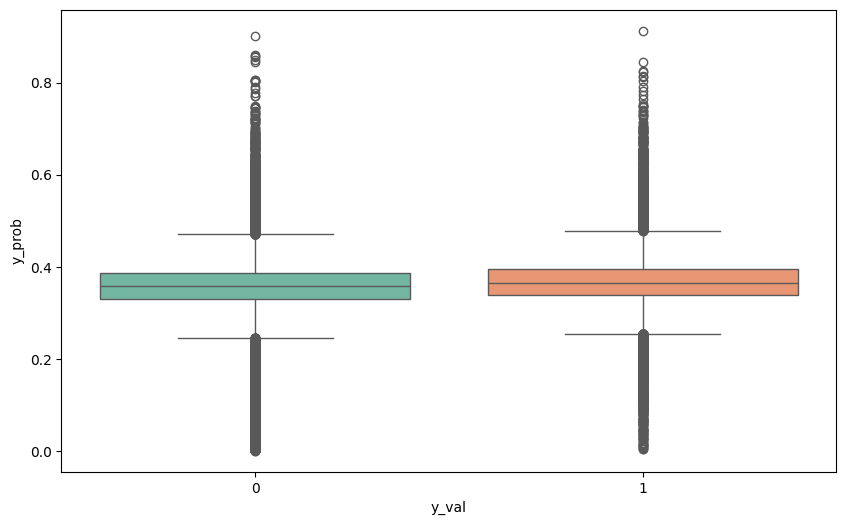

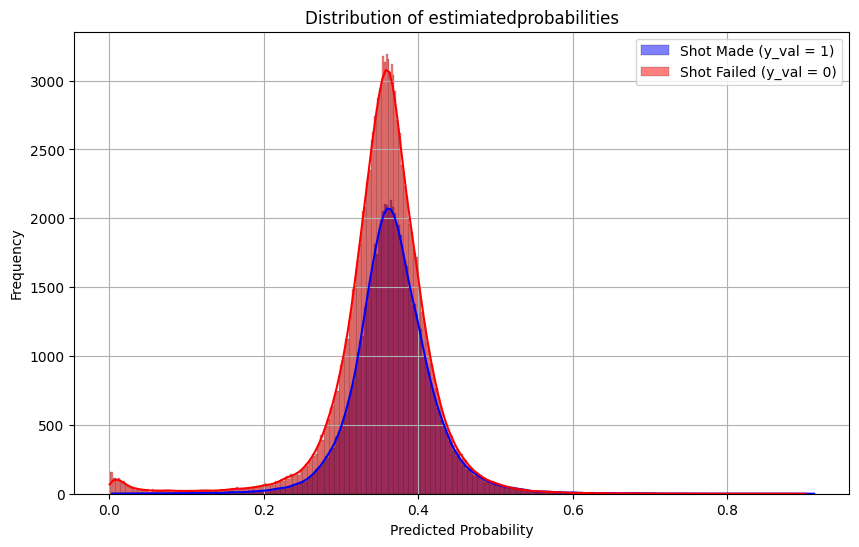

In [ ]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    three_pt_X_transfromed, y_three_pt, test_size=0.3, random_state=20
)

XGB_3pt = XGBClassifier(objective="binary:logistic")
XGB_3pt.fit(X_train, y_train)

y_pred = XGB_3pt.predict(X_val)
y_prob = XGB_3pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB_3pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.6227157266517054
Precision: 0.6621926345609065
Recall: 0.5559244478902582
F1-Score: 0.6044231380853754
Logistic Regression:


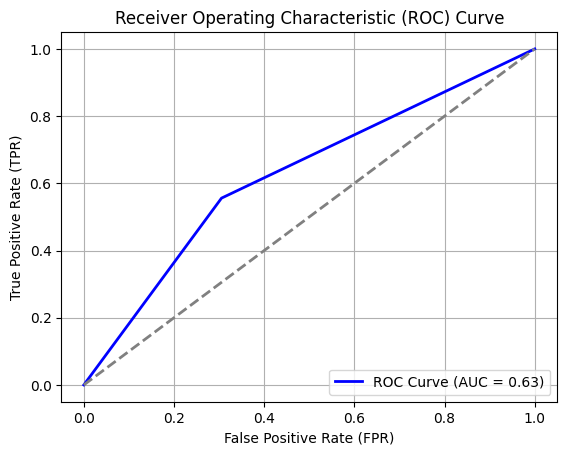

<ipython-input-83-b001635c6899>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


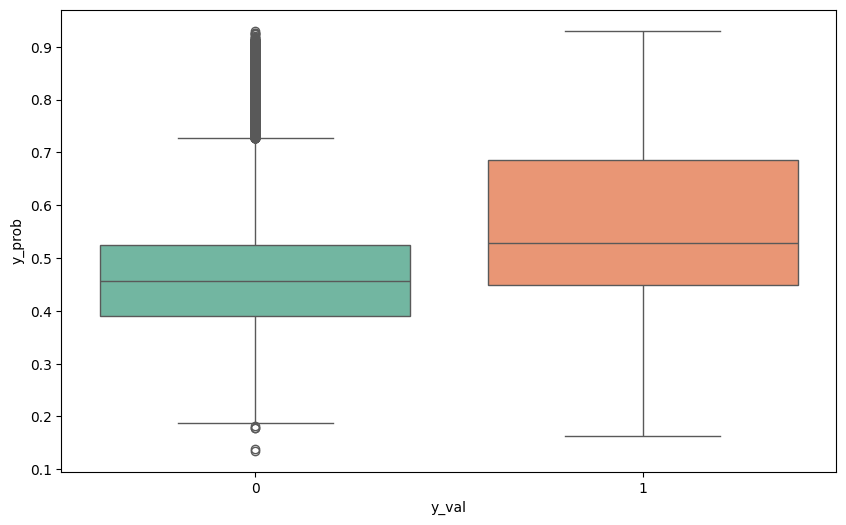

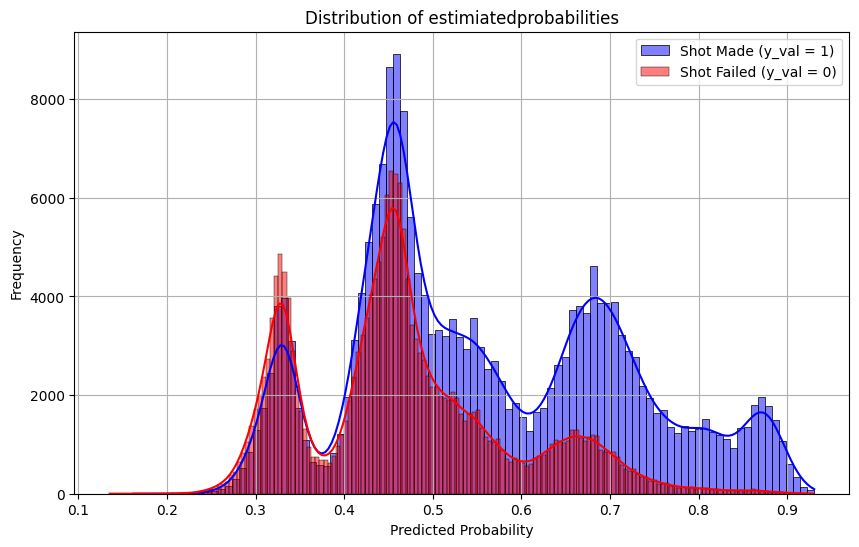

In [ ]:
logistic_regression_2pt = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters

X_train, X_val, y_train, y_val = train_test_split(
    two_pt_X_transfromed, y_two_pt, test_size=0.3, random_state=20
)

logistic_regression_2pt.fit(X_train, y_train)
y_pred = logistic_regression_2pt.predict(X_val)
y_prob = logistic_regression_2pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

print("Logistic Regression:")
plot_roc_curve(logistic_regression_2pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.6400598924658001
Precision: 0.45
Recall: 0.00022691459186889378
F1-Score: 0.0004536004536004536
Logistic Regression:


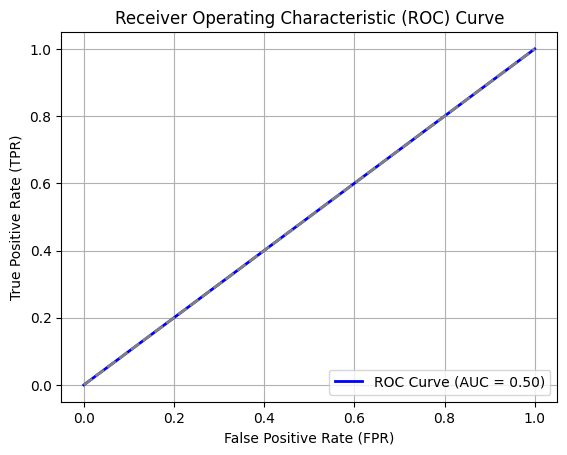

<ipython-input-84-d079d556044d>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


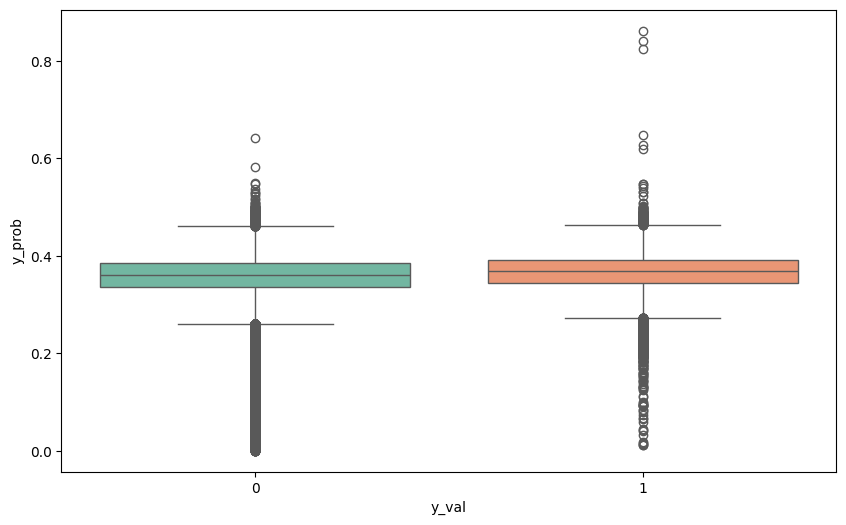

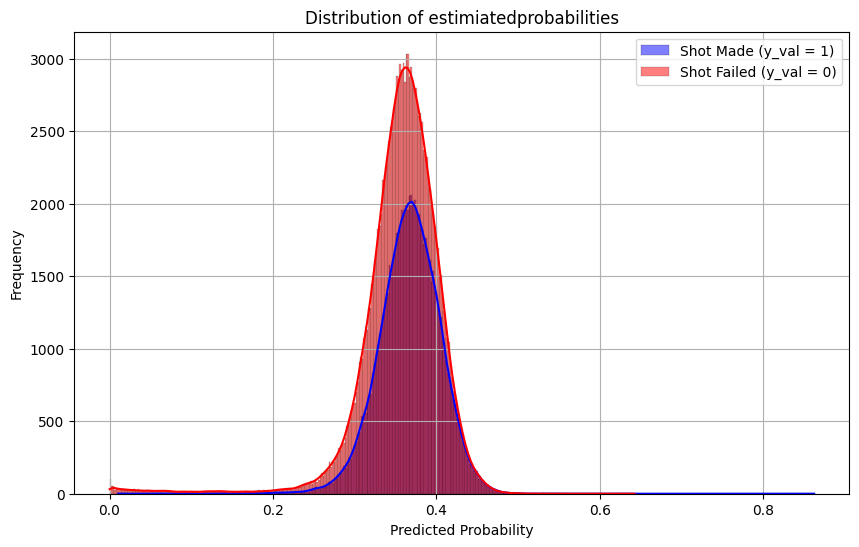

In [ ]:
logistic_regression_3pt = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters

X_train, X_val, y_train, y_val = train_test_split(
    three_pt_X_transfromed, y_three_pt, test_size=0.3, random_state=20
)

logistic_regression_3pt.fit(X_train, y_train)
y_pred = logistic_regression_3pt.predict(X_val)
y_prob = logistic_regression_3pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

print("Logistic Regression:")
plot_roc_curve(logistic_regression_3pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
estimated = X_val.copy()
estimated["y_prob"] = y_prob
estimated["y_val"] = y_val

In [ ]:
estimated.head()

,PLAYER_AVG_SHOT_RATE,PLAYER_AVG_3PT_RATE,PLAYER_AVG_2PT_RATE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,SECS_LEFT,interaction_term_distance_3ptrate,interaction_term_distance_2ptrate,...,BASIC_ZONE_Restricted Area,BASIC_ZONE_Right Corner 3,IS_PLAYER_HOME_False,POSITION_C,POSITION_PF,POSITION_SF,POSITION_SG,POSITION_PG,y_prob,y_val
466812,-0.030534,1.261185,-0.431506,0.096403,-0.463728,1.135802,1.337851,-0.162325,1.603167,1.066891,...,0.0,0.0,1.0,0,0,0,1,0,0.408686,1
448636,-0.578734,0.460891,-0.819581,-0.133534,-0.467236,1.135802,-0.424711,0.526063,1.210521,0.971915,...,0.0,0.0,1.0,0,0,0,0,1,0.369441,0
1984448,-0.761467,0.594274,-0.819581,-0.778426,2.193268,1.231829,-0.424711,-0.506519,1.375432,1.061193,...,0.0,0.0,1.0,0,0,0,1,0,0.356220,0
1122303,0.517666,0.327509,0.732719,2.462076,-0.881716,0.943749,-1.305991,1.730742,0.956609,1.142872,...,0.0,0.0,1.0,0,1,0,0,0,0.400670,0
1033197,-0.213267,0.594274,-0.237469,-2.457498,-0.542649,0.943749,0.456570,1.271817,1.077021,0.924428,...,0.0,1.0,1.0,0,0,0,0,1,0.404691,0


Text(0, 0.5, 'Shot Distance')

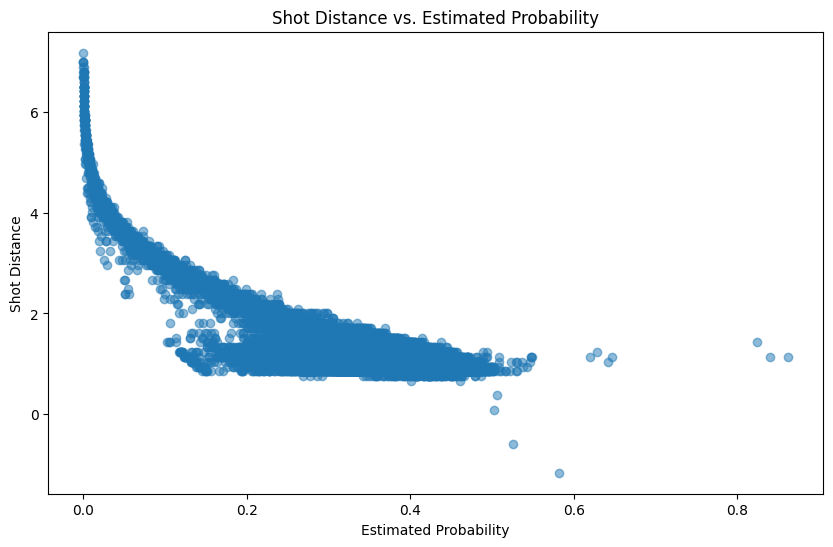

In [ ]:
plt.figure(figsize = (10, 6))
plt.scatter(estimated["y_prob"], estimated["SHOT_DISTANCE"], alpha = 0.5)
plt.title("Shot Distance vs. Estimated Probability")
plt.xlabel("Estimated Probability")
plt.ylabel("Shot Distance")

Text(0, 0.5, 'Player AVG 3PT Rate')

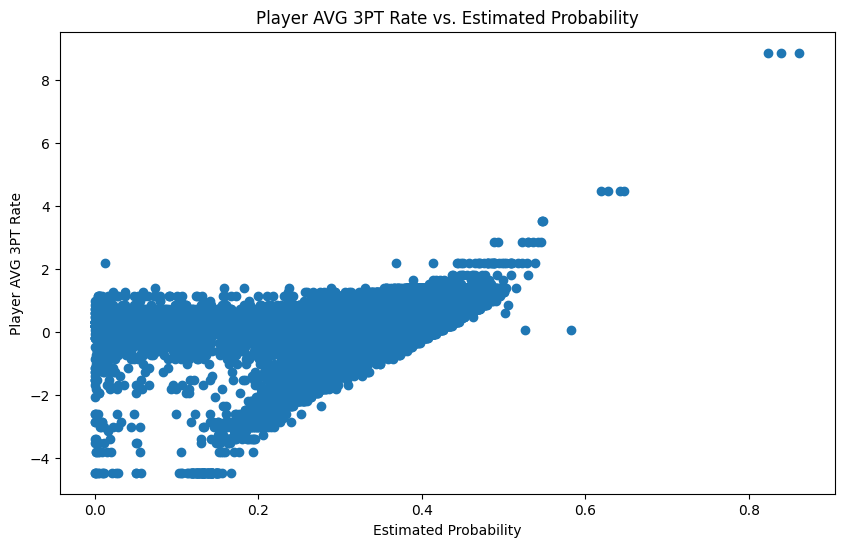

In [ ]:
plt.figure(figsize = (10, 6))
plt.scatter(estimated["y_prob"], estimated["PLAYER_AVG_3PT_RATE"])
plt.title("Player AVG 3PT Rate vs. Estimated Probability")
plt.xlabel("Estimated Probability")
plt.ylabel("Player AVG 3PT Rate")

In [ ]:
from scipy.stats import ttest_ind

succeddful = estimated[estimated['y_val'] == 0]
failed = estimated[estimated['y_val'] == 1]

results =[]
for col in estimated.columns:
  if col != 'y_val' and col != 'y_prob':
    t_statistic, p_value = ttest_ind(succeddful[col], failed[col])
    results.append({'column': col, 't_statistic': t_statistic, 'p_value': p_value})

results_df = pd.DataFrame(results)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
significantly_different= results_df[results_df["p_value"]<0.05]

In [ ]:
new_features = significantly_different.sort_values(by="p_value")["column"].values

In [ ]:
len(new_features)

35

<ipython-input-150-b5d8c3c634f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='y_val', ylabel='PLAYER_AVG_3PT_RATE'>

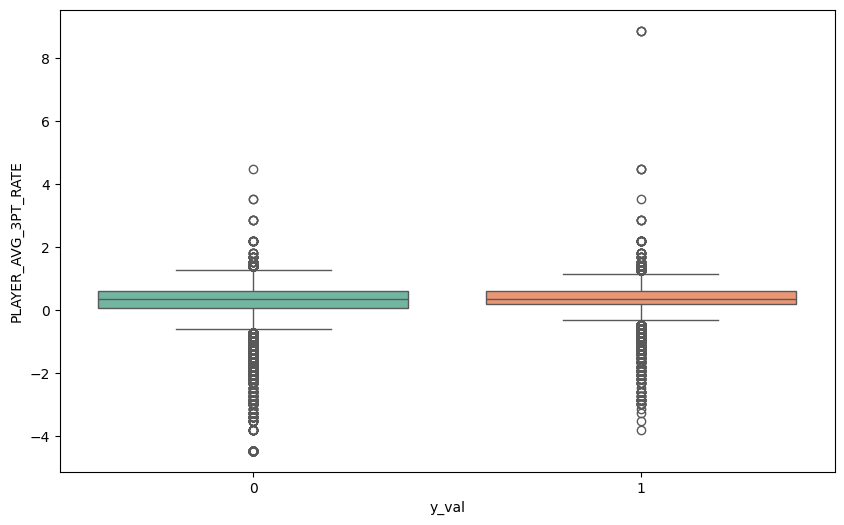

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="PLAYER_AVG_3PT_RATE",
    data=estimated,
    palette="Set2",
)

<ipython-input-151-f176244130f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='y_val', ylabel='SHOT_DISTANCE'>

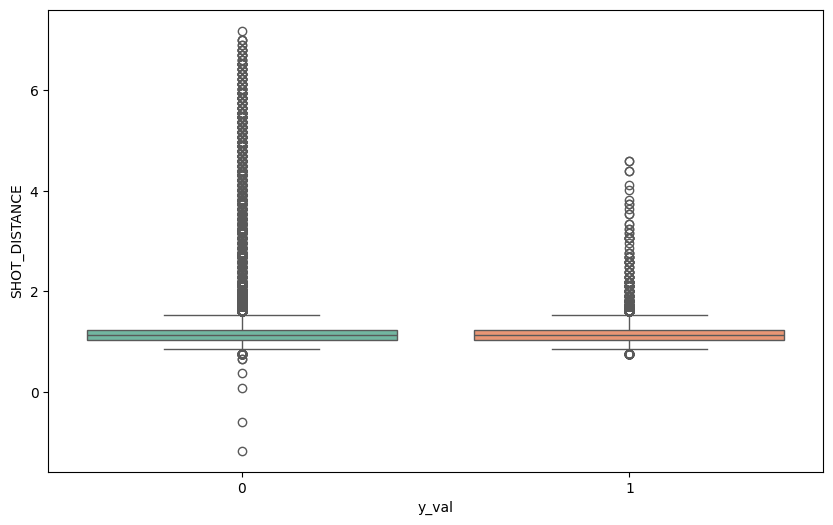

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="SHOT_DISTANCE",
    data=estimated,
    palette="Set2",
)

<ipython-input-152-f434df9af3cd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='y_val', ylabel='interaction_term_distance_playerrate'>

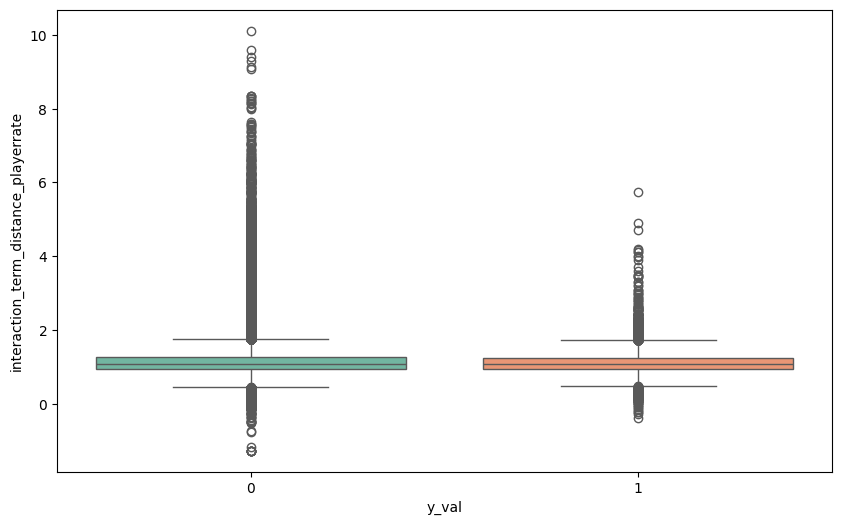

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="interaction_term_distance_playerrate",
    data=estimated,
    palette="Set2",
)

In [ ]:
significantly_different.sort_values(by="p_value")

,column,t_statistic,p_value
1,PLAYER_AVG_3PT_RATE,-35.419002,5.170311e-274
5,SHOT_DISTANCE,33.205393,3.566147e-241
11,distance_sqiared,31.073748,1.568393e-211
79,ZONE_ABB_BC,26.543489,5.364414e-155
88,ZONE_RANGE_Back Court Shot,26.543489,5.364414e-155
9,interaction_term_distance_2ptrate,26.295668,3.698803e-152
12,interaction_term_2pt_3pt,-25.755273,4.637047e-146
91,BASIC_ZONE_Backcourt,25.617697,1.580159e-144
10,interaction_term_distance_playerrate,24.885282,1.660085e-136
86,ZONE_RANGE_24+ ft.,-24.340283,1.094780e-130


Accuracy: 0.6400553551577849
Precision: 0.43902439024390244
Recall: 0.00022691459186889378
F1-Score: 0.0004535947383010357
Logistic Regression:


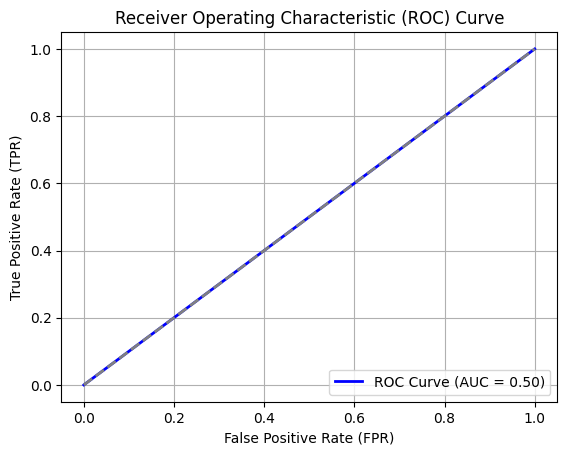

<ipython-input-131-81391c680812>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


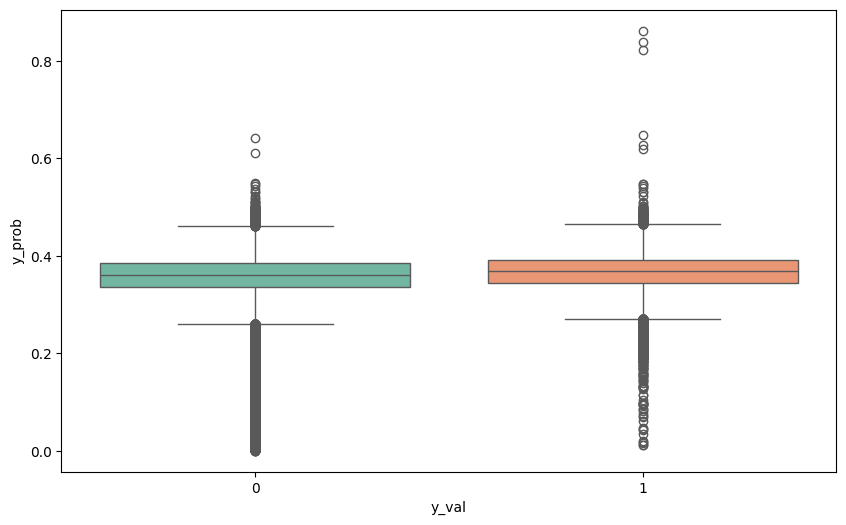

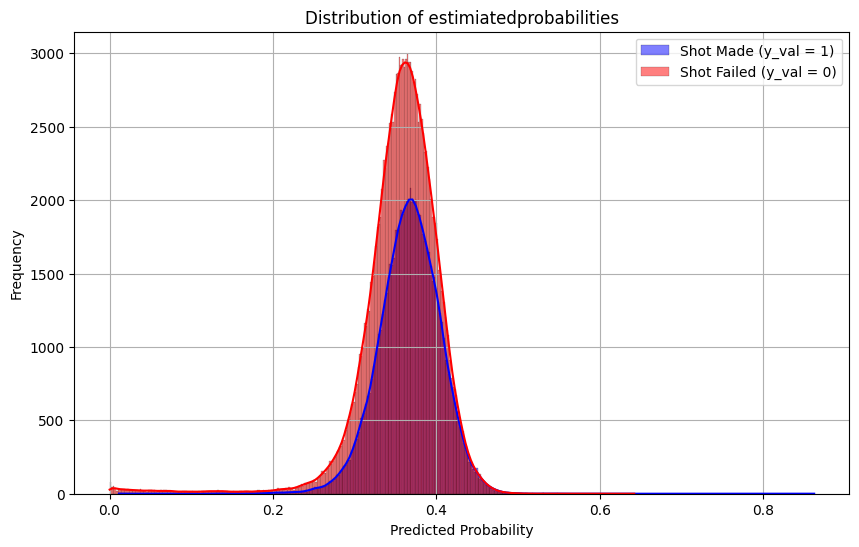

In [ ]:
logistic_regression_3pt = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters

X_train, X_val, y_train, y_val = train_test_split(
    three_pt_X_transfromed[new_features], y_three_pt, test_size=0.3, random_state=20
)

logistic_regression_3pt.fit(X_train, y_train)
y_pred = logistic_regression_3pt.predict(X_val)
y_prob = logistic_regression_3pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

print("Logistic Regression:")
plot_roc_curve(logistic_regression_3pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.6392114158669662
Precision: 0.4618457850579305
Recall: 0.014572959344468957
F1-Score: 0.02825438725130762


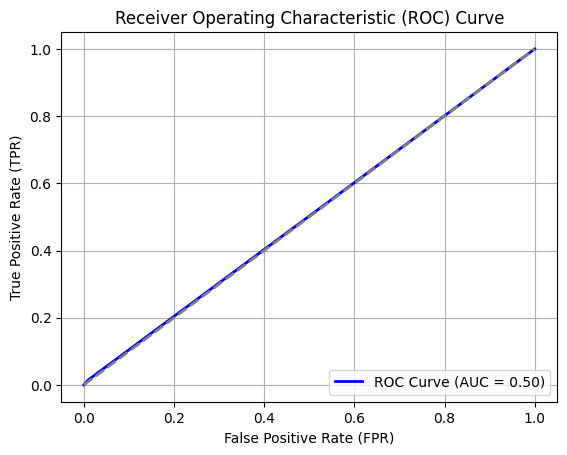

<ipython-input-132-f2488b5f38bc>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


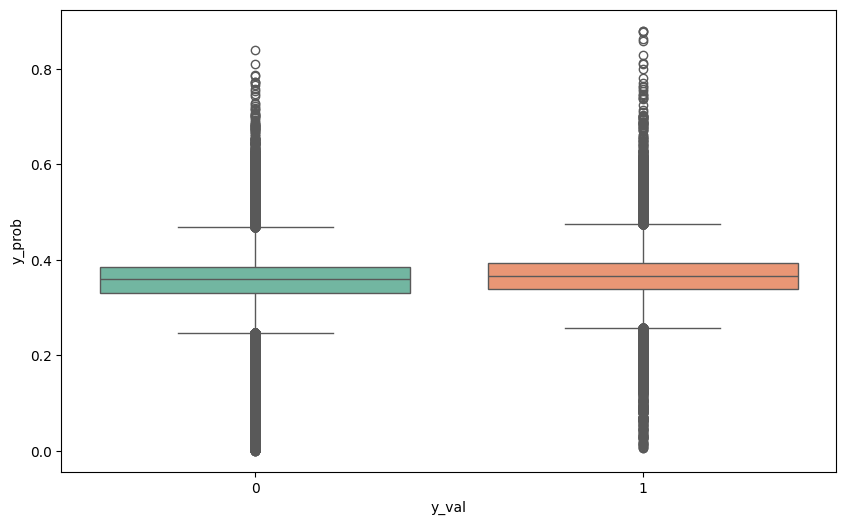

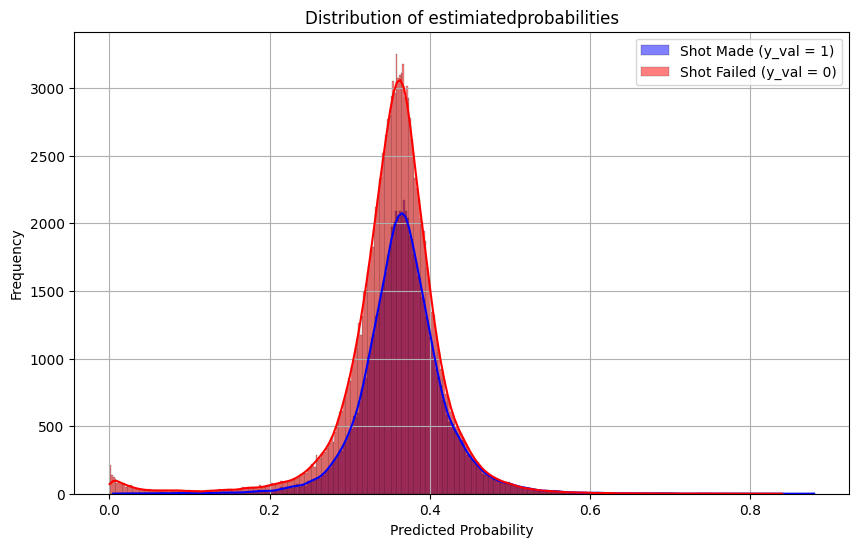

In [ ]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(
    three_pt_X_transfromed[new_features], y_three_pt, test_size=0.3, random_state=20
)

XGB_3pt = XGBClassifier(objective="binary:logistic")
XGB_3pt.fit(X_train, y_train)

y_pred = XGB_3pt.predict(X_val)
y_prob = XGB_3pt.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB_3pt, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Semi-conclusion: Predicting 3-pt shots are nearly like a 'RANDOM-GUESS'

Text(0.5, 1.0, '3pt shots per game of players')

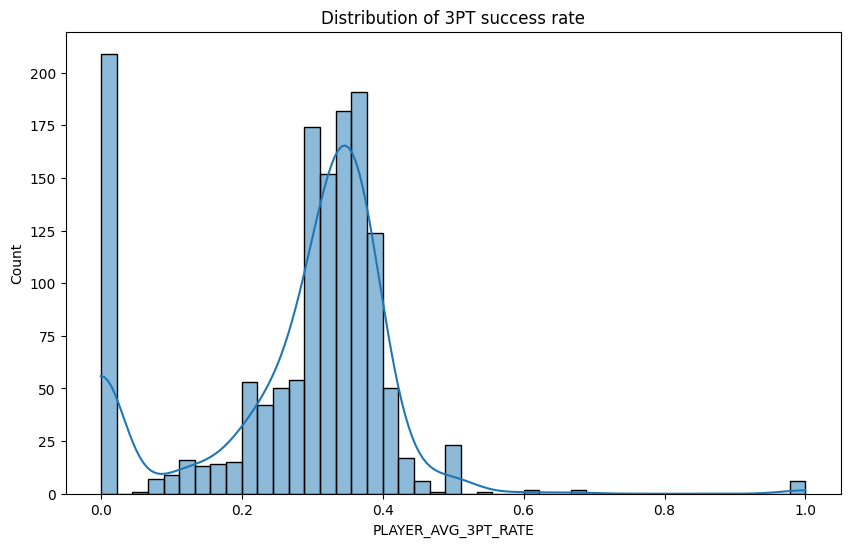

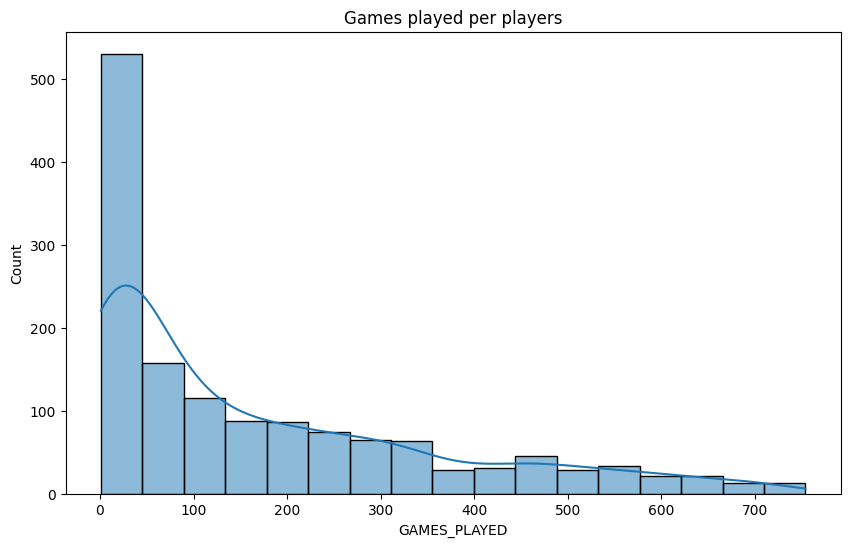

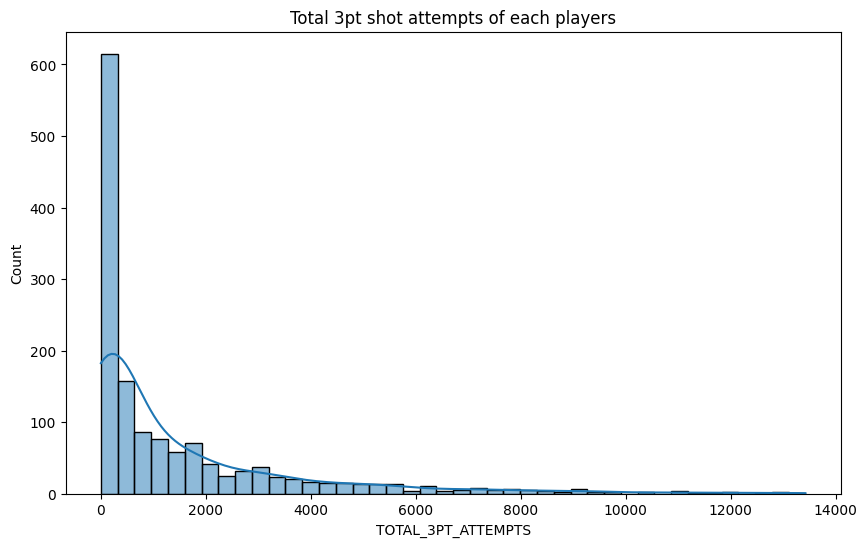

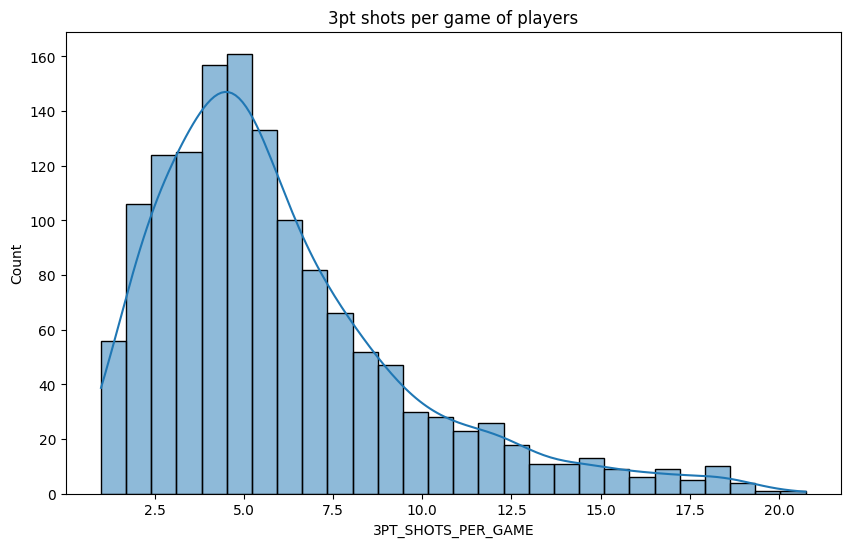

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(grouped_df1.PLAYER_AVG_3PT_RATE, kde=True)
plt.title("Distribution of 3PT success rate")

grouped_df = df.groupby("PLAYER_ID").agg(
    GAMES_PLAYED=("GAME_ID", "nunique"),  # Count unique games per player
    TOTAL_3PT_ATTEMPTS=("PLAYER_AVG_3PT_RATE", "count"),  # Count 3PT shot attempts
    AVG_3PT_RATE=("PLAYER_AVG_3PT_RATE", "mean")  # Average 3PT rate
).reset_index()

grouped_df["3PT_SHOTS_PER_GAME"] = grouped_df["TOTAL_3PT_ATTEMPTS"] / grouped_df["GAMES_PLAYED"]

plt.figure(figsize=(10, 6))
sns.histplot(grouped_df.GAMES_PLAYED, kde=True)
plt.title("Games played per players")

plt.figure(figsize=(10, 6))
sns.histplot(grouped_df.TOTAL_3PT_ATTEMPTS, kde=True)
plt.title("Total 3pt shot attempts of each players")

plt.figure(figsize=(10, 6))
sns.histplot(grouped_df["3PT_SHOTS_PER_GAME"], kde=True)
plt.title("3pt shots per game of players")